# Overplotting AIA Data on an HMI Magnetogram

In [1]:
from __future__ import print_function,division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from astropy.coordinates import SkyCoord

from sunpy.map import Map
from sunpy.net import Fido, attrs as a
from sunpy.time import TimeRange

%matplotlib inline

First, collect the needed data. We're going to look at active region NOAA 12671 which was near disk center the day of the Great American Eclipse, 21 August 2017. We'll pull down the HMI magnetogram data as well as the 171 and 211 channels of AIA.

In [9]:
result = Fido.search(
    a.Time(TimeRange('2017/08/21 18:15',10*u.s)),
    a.Instrument('AIA'),
    a.Wavelength(171*u.angstrom,171*u.angstrom)
)

In [10]:
aia_171file = Fido.fetch(result)[0]

[                                        =============================

In [11]:
result = Fido.search(
    a.Time(TimeRange('2017/08/21 18:15',10*u.s)),
    a.Instrument('AIA'),
    a.Wavelength(211*u.angstrom,211*u.angstrom)
)

In [12]:
aia_211file = Fido.fetch(result)[0]

[                                        ==================================

In [13]:
result = Fido.search(
    a.Time(TimeRange('2017/08/21 18:15',1*u.min)),
    a.Instrument('HMI') & a.vso.Physobs('LOS_magnetic_field')
)

In [14]:
hmi_file = Fido.fetch(result)[0]

[                                        ============================

We want to crop around only the active region of interest.

In [200]:
left_corner = (0*u.arcsec,-90*u.arcsec)
right_corner = (600*u.arcsec,300*u.arcsec)

Additionally, we'll need to rotate and center each map in order to properly align them. We'll create a simple function to do this which is identical to `sunpy.instr.aia.aiaprep`.

In [201]:
def prep(sdomap):
    if (sdomap.scale[0] / 0.6).round() != 1.0 * u.arcsec and sdomap.data.shape != (4096, 4096):
        scale = (sdomap.scale[0] / 0.6).round() * 0.6 * u.arcsec
    else:
        scale = 0.6 * u.arcsec  
    scale_factor = sdomap.scale[0] / scale
    tempmap = sdomap.rotate(recenter=True, scale=scale_factor.value, missing=sdomap.min())
    center = np.floor(tempmap.meta['crpix1'])
    range_side = (center + np.array([-1, 1]) * sdomap.data.shape[0] / 2) * u.pix
    newmap = tempmap.submap(u.Quantity([range_side[0], range_side[0]]),
                            u.Quantity([range_side[1], range_side[1]]))
    newmap.meta['r_sun'] = newmap.meta['rsun_obs'] / newmap.meta['cdelt1']
    newmap.meta['lvl_num'] = 1.5

    return newmap

Now derotate, rescale, and properly crop each map. Note that after we crop the AIA 171 image, we use the resulting bounding box to crop the 211 and HMI maps.

In [203]:
aia_171map = prep(Map(aia_171file))
bottom_left_coord = SkyCoord(*left_corner,frame=aia_171map.coordinate_frame)
top_right_coord = SkyCoord(*right_corner,frame=aia_171map.coordinate_frame)
aia_171map = aia_171map.submap(bottom_left_coord,top_right_coord)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1282: Warning: GenericMap.submap now takes pixel values as `bottom_left` and `top_right` not `range_a` and `range_b`
  " and `top_right` not `range_a` and `range_b`", Warning)


In [204]:
aia_211map = prep(Map(aia_211file))
aia_211map = aia_211map.submap(aia_171map.bottom_left_coord,aia_171map.top_right_coord)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1282: Warning: GenericMap.submap now takes pixel values as `bottom_left` and `top_right` not `range_a` and `range_b`
  " and `top_right` not `range_a` and `range_b`", Warning)


In [207]:
hmi_map = prep(Map(hmi_file).rotate())
hmi_map = hmi_map.submap(aia_171map.bottom_left_coord,aia_171map.top_right_coord)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1282: Warning: GenericMap.submap now takes pixel values as `bottom_left` and `top_right` not `range_a` and `range_b`
  " and `top_right` not `range_a` and `range_b`", Warning)


Finally, plot the maps on top of each other. We'll blend the 171 and 211 channels by adjusting the transparency and then overplot the HMI contours. This shows how the underlying magnetic field influences the structures that we observe in EUV emission.

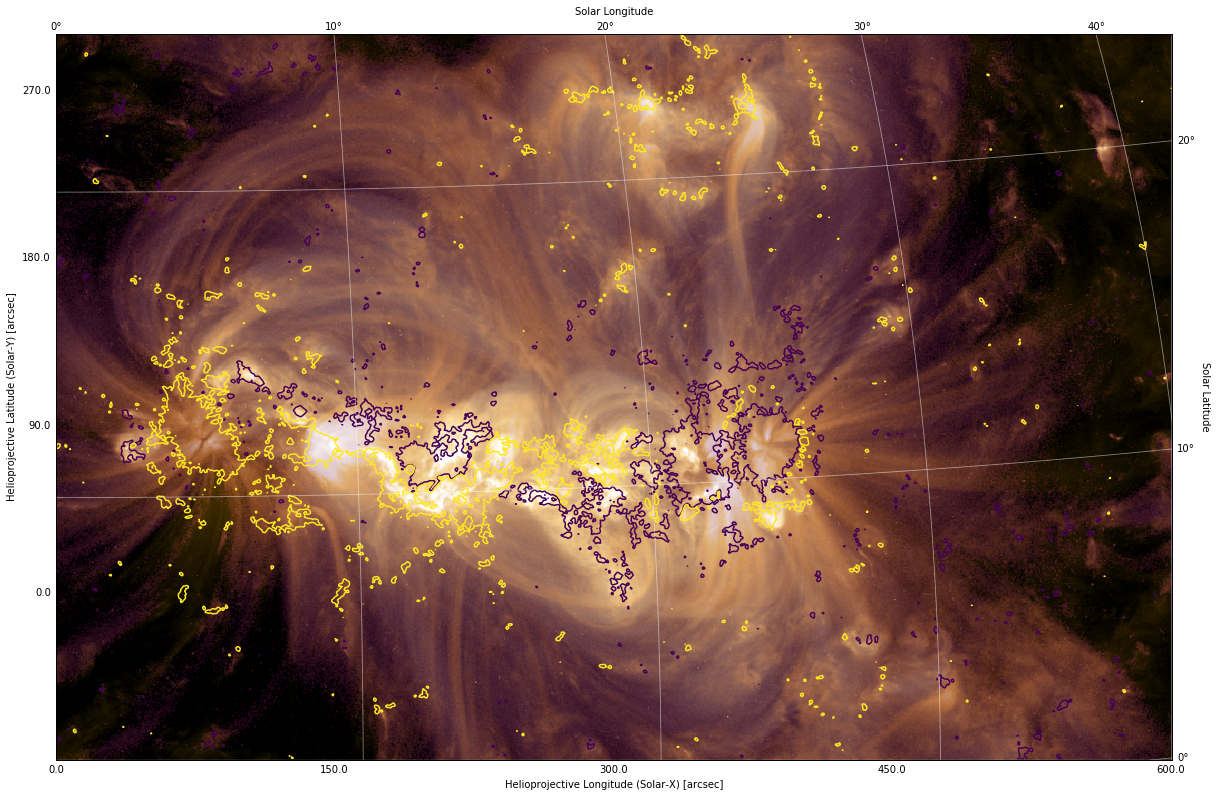

In [208]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection=hmi_map)
## HMI
hmi_map.draw_contours([-5,5]*u.percent,axes=ax)
hmi_map.draw_grid(axes=ax,grid_spacing=10*u.deg,color='w')
## AIA 171
norm = matplotlib.colors.LogNorm(vmin=75,vmax=3e3)
im = aia_171map.plot(axes=ax,norm=norm,title=False,)
im.set_alpha(1)
## AIA 211
im = aia_211map.plot(axes=ax,norm=norm,title=False)
im.set_alpha(0.65)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)